# RNN for Mnist handwritten numeral recognition

In [1]:
import torch
import torch.utils.data as Data
import torchvision     
import torch.nn as nn
from torch.autograd import Variable

# torch.manual_seed(1)   

### 1.Mnist 数据集 

In [2]:
DOWNLOAD_MNIST = False  
'''Mnist 手写数字数据集'''

# 训练数据
train_data = torchvision.datasets.MNIST(
    root="./mnist/",   
    train=True,  # this is training data
    transform=torchvision.transforms.ToTensor(), #数据转换为torch.FloatTensor (C x H x W)
    download=DOWNLOAD_MNIST        
)

# 测试数据
test_data = torchvision.datasets.MNIST(root="./mnist/", 
                                       train=False)
 
print('#train_data:', len(train_data))
print('#test_data:', len(test_data))

#train_data: 60000
#test_data: 10000


### 2. 构造 Dataloader 

In [ ]:
# batch, 50samples, 1 channel, 28x28 (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, 
                               batch_size=64, 
                               shuffle=True)
 
# 测试前2000个
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]

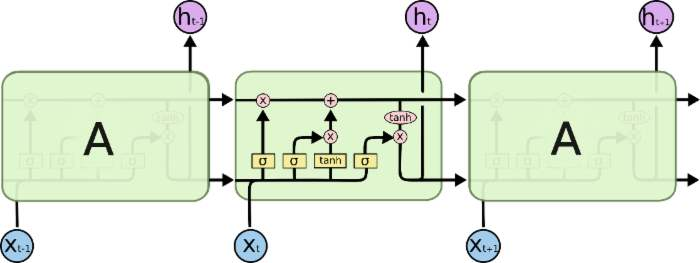

In [4]:
from IPython.display import Image
Image("LSTM.jpg", width=800)

In [5]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=28,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

### 4. 训练模型 

In [6]:
learning_rate = 0.001
epochs = 1

model = RNN()
print('{} Model Architecture {}'.format('='*30, '='*30))
print(model)  

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted

============================== Model Architecture ==============================
RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [18]:
# training and testing
print('{} Training and Testing {}'.format('='*30, '='*30))
for epoch in range(epochs):
    for step, (batch_x, batch_y) in enumerate(train_loader):
        batch_x = batch_x.view(-1, 28, 28)              # reshape x to (batch, time_step, input_size)
        output = model(batch_x)                         # rnn output
        loss = loss_func(output, batch_y)               # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients
  
        if step % 100 == 0:
            test_output = model(test_x.view(-1, 28, 28))                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum())/float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            
print('{} Finish {}'.format('='*35, '='*35))

============================== Training and Testing ==============================
Epoch:  0 | train loss: 0.1132 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1241 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2704 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1834 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0521 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2039 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1616 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1974 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1073 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2147 | test accuracy: 0.95


### 5. 测试 & 可视化

In [23]:
test_output = model(test_x.view(-1, 28, 28)) 
test_x_output = test_x.view(-1, 28*28) 
pred_y = torch.max(test_output, 1)[1].data.numpy()

print('#predictions\t', pred_y[:10])
print('#ground truth\t', test_y[:10].numpy())

#predictions	 [7 2 1 0 4 1 4 9 5 9]
#ground truth	 [7 2 1 0 4 1 4 9 5 9]


In [26]:
from sklearn.manifold import TSNE
# 降维
tsne = TSNE(perplexity=30, 
            n_components=2, 
            init='pca', 
            n_iter=1000)

plot_only = 500
low_dim_embs = tsne.fit_transform(test_x_output.data.numpy()[:plot_only,:])
labels = test_y.numpy()[:plot_only]

print('#low_dim_embs.shape:', low_dim_embs.shape)
print('#labels.shape:', labels.shape)

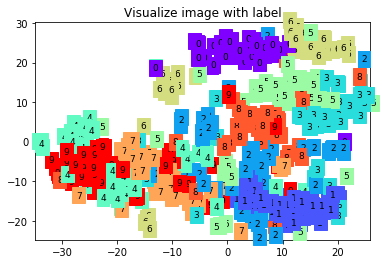

In [27]:
import matplotlib.pyplot as plt
from matplotlib import cm

plt.cla()
X, Y = low_dim_embs[:, 0], low_dim_embs[:, 1]
for x, y, s in zip(X, Y, labels):
    c = cm.rainbow(int(255*s/9)); 
    plt.text(x, y, s, backgroundcolor=c, fontsize=9)

plt.xlim(X.min(), X.max()) 
plt.ylim(Y.min(), Y.max())
plt.title('RNN-Visualize image with label')
plt.show()
plt.pause(0.01)